In [1]:
%matplotlib inline

In [3]:
import gc
import numpy as np
import pandas as pd
from datetime import datetime

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

from scipy.stats import kruskal
import scipy

from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tslearn.metrics import dtw

from xgboost import plot_importance

In [4]:
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    return 100 * np.mean(smap)
def vsmape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    return 100 * smap

In [5]:
smape_scorer = make_scorer(smape, greater_is_better=False)

In [6]:
BASE = './'
census = pd.read_csv(BASE + 'census_starter.csv')
train = pd.read_csv(BASE + 'train.csv')
test = pd.read_csv(BASE + 'test.csv')
sub = pd.read_csv(BASE + 'sample_submission.csv')

In [7]:
BASE_update = './12/'
train_add12 = pd.read_csv(BASE_update + 'revealed_test.csv')

In [8]:
train = pd.concat((train, train_add12)).sort_values(['cfips','row_id']).reset_index(drop=True)

In [9]:
test['first_day_of_month'].unique()

array(['2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
       '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01'],
      dtype=object)

In [10]:
import copy
sub_list = copy.deepcopy(list(test['first_day_of_month'].unique()))

In [11]:
sub_list

['2022-11-01',
 '2022-12-01',
 '2023-01-01',
 '2023-02-01',
 '2023-03-01',
 '2023-04-01',
 '2023-05-01',
 '2023-06-01']

In [12]:
for i in train_add12['first_day_of_month'].unique():
    test = test.drop(test.loc[test['first_day_of_month']==i].index,axis=0)

In [13]:
train['first_day_of_month'].unique()

array(['2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
       '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
       '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
       '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
       '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
       '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
       '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
       '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
       '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
       '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
       '2022-12-01'], dtype=object)

In [14]:
test['first_day_of_month'].unique()

array(['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
       '2023-05-01', '2023-06-01'], dtype=object)

In [15]:
print(train.shape, test.shape, sub.shape)

(128535, 7) (18810, 3) (25080, 2)


In [16]:
train.columns

Index(['row_id', 'cfips', 'county', 'state', 'first_day_of_month',
       'microbusiness_density', 'active'],
      dtype='object')

In [17]:
def transpose_raw(raw, col):
    #raw_group_transpse = raw.drop(['row_id','county','state'],axis=1)
    raw_group_transpse = raw.drop(list(set(raw.columns) - set([col,'cfips'])),axis=1)
    raw_group_transpse_perfect = raw_group_transpse.groupby('cfips').apply(lambda x: x.drop(['cfips'],axis=1)[[col]].transpose())
    raw_transpse = raw_group_transpse_perfect.reset_index().set_index(keys='cfips').drop(['level_1'],axis=1)
    return raw_transpse

In [18]:
def raw_add_col(transpose_active, raw, col):
    raw_col = raw[['cfips',col]]
    raw_col_idx = raw_col.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False).dropna(axis=0)
    raw2 = transpose_active.merge(raw_col_idx,on="cfips", how="left", sort=False)
    return raw2

In [19]:
def creat_raw(col):
    raw = pd.concat((train, test)).sort_values(['cfips','row_id']).reset_index(drop=True)
    raw_co = raw.set_index(keys='first_day_of_month')
    raw_group_transpse = raw_co.drop(['row_id','county','state'],axis=1)
    raw_group_transpse_perfect = raw_group_transpse.groupby('cfips').apply(lambda x: x.drop(['cfips'],axis=1)[[col]].transpose())
    raw_transpse = raw_group_transpse_perfect.reset_index().set_index(keys='cfips').drop(['level_1'],axis=1)
    raw_group_transpse = raw.drop(list(set(raw.columns) - set([col,'cfips'])),axis=1)
    raw_trans = raw.set_index(keys='first_day_of_month')
    transpose_ = transpose_raw(raw_trans, col)
    raw_county = raw[['cfips','county']]
    raw_county_idx = raw_county.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False).dropna(axis=0)
    raw2 = transpose_.merge(raw_county_idx,on="cfips", how="left", sort=False)
    transpose_ = raw_add_col(transpose_, raw, 'county')
    transpose_ = raw_add_col(transpose_, raw, 'state')

    le = LabelEncoder()
    transpose_['county'] = le.fit_transform(transpose_['county'])
    transpose_['state'] = le.fit_transform(transpose_['state'])

    date_list = []

    for elem in transpose_:
        try:
            date = datetime.strptime(elem, '%Y-%m-%d')
            date_list.append(elem)
        except ValueError:
            continue

    initialized_df = transpose_.copy()
    return initialized_df, date_list

In [20]:
transpose_microbusiness_density, date_list = creat_raw('microbusiness_density')

In [21]:
initialized_df = transpose_microbusiness_density.copy()

In [22]:
transpose_active, date_list = creat_raw('active')

In [23]:
pd.options.display.max_columns = 100

In [32]:
transpose_microbusiness_density[transpose_microbusiness_density.columns[19:-8]]

,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
0,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917,3.186722,3.203320,3.200948,3.286307,3.296781,3.334431,3.336785,3.372082,3.313253,3.346197,3.437971,3.423852,3.442677,3.463856,3.442677,3.470915
1,7.909001,7.978031,8.032654,8.061466,8.077073,7.984033,7.918605,7.802155,7.832168,7.900597,7.930010,7.733397,7.823300,7.945311,7.979170,7.907365,8.507496,8.573463,8.491150,8.341701,8.359798,8.257636,8.250630
2,1.072105,1.057146,1.102025,1.097038,1.107011,1.146903,1.156876,1.121971,1.136930,1.151890,1.151890,1.186629,1.206827,1.196728,1.191678,1.186629,1.191678,1.216926,1.196728,1.206827,1.232074,1.247223,1.252272
3,1.287650,1.287650,1.259657,1.259657,1.237263,1.237263,1.209271,1.186877,1.186877,1.231665,1.209271,1.214165,1.236650,1.264755,1.253513,1.247892,1.275998,1.326588,1.292861,1.315346,1.287240,1.275998,1.287240
4,1.688793,1.700081,1.702339,1.720401,1.713628,1.715885,1.711370,1.729432,1.731690,1.733947,1.752009,1.752923,1.777708,1.797986,1.764189,1.748417,1.773202,1.831783,1.836289,1.852060,1.831783,1.836289,1.852060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130,3.534121,3.540377,3.474698,3.449678,3.487208,3.434040,3.452806,3.362107,3.255770,3.093138,3.039970,2.926768,2.892446,2.848763,2.851883,2.820681,2.783238,2.836282,2.811320,2.811320,2.823801,2.814440,2.876845
3131,25.209639,25.358242,25.581148,25.591763,25.655451,25.602377,25.719137,25.517462,25.628914,25.666065,25.846514,25.532248,25.438322,25.636610,25.626175,25.506157,25.652266,25.939260,26.085369,26.090586,26.273220,26.372364,26.314966
3132,3.467531,3.481318,3.426168,3.426168,3.364125,3.364125,3.439956,3.481318,3.501999,3.481318,3.777747,3.754478,3.954258,4.023147,4.064481,3.885368,3.906035,3.981813,3.974924,3.995591,4.009369,4.016258,4.050703
3133,3.141015,3.256737,3.207142,3.157547,3.124483,3.124483,3.107952,3.058357,3.124483,3.058357,3.058357,3.027295,3.027295,3.010753,2.977668,2.944582,3.126551,3.225807,3.209264,3.209264,3.126551,3.143093,3.060380


In [42]:
temp_df = transpose_microbusiness_density[transpose_microbusiness_density.columns[19:42]]
temp_df

,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
0,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917,3.186722,3.203320,3.200948,3.286307,3.296781,3.334431,3.336785,3.372082,3.313253,3.346197,3.437971,3.423852,3.442677,3.463856,3.442677,3.470915
1,7.909001,7.978031,8.032654,8.061466,8.077073,7.984033,7.918605,7.802155,7.832168,7.900597,7.930010,7.733397,7.823300,7.945311,7.979170,7.907365,8.507496,8.573463,8.491150,8.341701,8.359798,8.257636,8.250630
2,1.072105,1.057146,1.102025,1.097038,1.107011,1.146903,1.156876,1.121971,1.136930,1.151890,1.151890,1.186629,1.206827,1.196728,1.191678,1.186629,1.191678,1.216926,1.196728,1.206827,1.232074,1.247223,1.252272
3,1.287650,1.287650,1.259657,1.259657,1.237263,1.237263,1.209271,1.186877,1.186877,1.231665,1.209271,1.214165,1.236650,1.264755,1.253513,1.247892,1.275998,1.326588,1.292861,1.315346,1.287240,1.275998,1.287240
4,1.688793,1.700081,1.702339,1.720401,1.713628,1.715885,1.711370,1.729432,1.731690,1.733947,1.752009,1.752923,1.777708,1.797986,1.764189,1.748417,1.773202,1.831783,1.836289,1.852060,1.831783,1.836289,1.852060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130,3.534121,3.540377,3.474698,3.449678,3.487208,3.434040,3.452806,3.362107,3.255770,3.093138,3.039970,2.926768,2.892446,2.848763,2.851883,2.820681,2.783238,2.836282,2.811320,2.811320,2.823801,2.814440,2.876845
3131,25.209639,25.358242,25.581148,25.591763,25.655451,25.602377,25.719137,25.517462,25.628914,25.666065,25.846514,25.532248,25.438322,25.636610,25.626175,25.506157,25.652266,25.939260,26.085369,26.090586,26.273220,26.372364,26.314966
3132,3.467531,3.481318,3.426168,3.426168,3.364125,3.364125,3.439956,3.481318,3.501999,3.481318,3.777747,3.754478,3.954258,4.023147,4.064481,3.885368,3.906035,3.981813,3.974924,3.995591,4.009369,4.016258,4.050703
3133,3.141015,3.256737,3.207142,3.157547,3.124483,3.124483,3.107952,3.058357,3.124483,3.058357,3.058357,3.027295,3.027295,3.010753,2.977668,2.944582,3.126551,3.225807,3.209264,3.209264,3.126551,3.143093,3.060380


In [43]:
42-19

23

## 여기부터 self_blacklist

In [50]:
arrays = []
for i in range(23+1):
    inner_list = [] # create 3x3 array with random values
    arrays.append(inner_list)

In [51]:
for i in range(len(temp_df)):
    arrays[temp_df.loc[i].nunique()].append(transpose_microbusiness_density.loc[i]['cfips'])

In [52]:
cnt=1
cnt_list = []
for i in arrays:
    print(cnt,':',len(i),end='  ')
    if cnt%3 == 0:
        print()
    cnt_list.append(len(i))
    cnt+=1
    

1 : 0  2 : 0  3 : 5  
4 : 6  5 : 11  6 : 13  
7 : 23  8 : 24  9 : 47  
10 : 68  11 : 68  12 : 87  
13 : 91  14 : 114  15 : 139  
16 : 155  17 : 169  18 : 177  
19 : 237  20 : 229  21 : 248  
22 : 293  23 : 356  24 : 575  


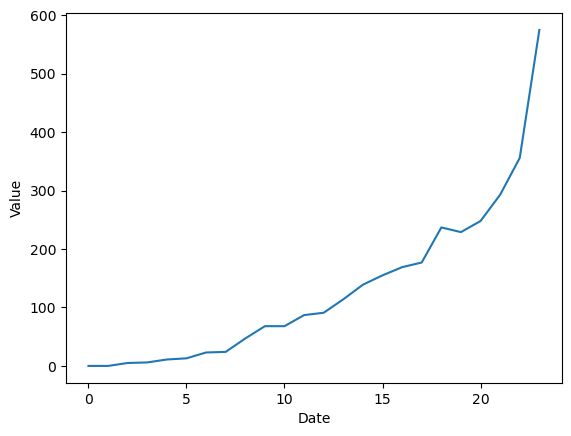

In [53]:
plt.plot(cnt_list)
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [54]:
values_list = []
cnt=1
for i in arrays:
    if cnt == 12:
        break
    if len(i)<=80:
        print(cnt,i)
        for item in i:
            values_list.append(item)
    cnt+=1

1 []
2 []
3 [13265.0, 28055.0, 31009.0, 48033.0, 48261.0]
4 [13101.0, 16033.0, 31115.0, 31165.0, 48301.0, 48393.0]
5 [2282.0, 20101.0, 31005.0, 31007.0, 31085.0, 31149.0, 31183.0, 38087.0, 48173.0, 48205.0, 48269.0]
6 [15005.0, 31069.0, 31113.0, 35021.0, 38047.0, 38083.0, 46007.0, 46031.0, 46069.0, 46075.0, 46137.0, 48105.0, 55078.0]
7 [2013.0, 17047.0, 20033.0, 20071.0, 20187.0, 30011.0, 30069.0, 30107.0, 30109.0, 31073.0, 31077.0, 31091.0, 31103.0, 31133.0, 38041.0, 38065.0, 38095.0, 46003.0, 46017.0, 48263.0, 48311.0, 49009.0, 51081.0]
8 [5013.0, 13307.0, 17069.0, 19159.0, 20039.0, 21189.0, 27125.0, 28125.0, 30059.0, 30103.0, 31015.0, 31063.0, 31087.0, 38011.0, 38037.0, 40057.0, 42023.0, 46049.0, 46063.0, 46089.0, 47127.0, 48345.0, 48413.0, 54101.0]
9 [2164.0, 2230.0, 5099.0, 6003.0, 13209.0, 16025.0, 20025.0, 20047.0, 20049.0, 20075.0, 20083.0, 20109.0, 20135.0, 20195.0, 20199.0, 20203.0, 29045.0, 29067.0, 29179.0, 30033.0, 30051.0, 30079.0, 31057.0, 31093.0, 31123.0, 31161.0, 3501

In [55]:
len(values_list)

265

transpose_microbusiness_density[transpose_microbusiness_density['cfips'].isin(arrays[6])]

transpose_microbusiness_density[transpose_microbusiness_density['cfips'].isin(arrays[7])]

transpose_microbusiness_density[transpose_microbusiness_density['cfips'].isin(arrays[8])]

transpose_microbusiness_density[transpose_microbusiness_density['cfips'].isin(arrays[9])]

transpose_microbusiness_density[transpose_microbusiness_density['cfips'].isin(arrays[10])]

transpose_microbusiness_density[transpose_microbusiness_density['cfips'].isin(arrays[11])]

transpose_microbusiness_density[transpose_microbusiness_density['cfips'].isin(arrays[15])]

In [57]:
### 잠깐 0인 애들은 뭐지? 결측치 확인 좀 해보자 우선 0701에서 1201까지 0인 값을 가지는 애들을 보자

In [58]:
temp_df_ = transpose_microbusiness_density[transpose_microbusiness_density.columns[19:42]]

In [59]:
temp_df_.loc[(temp_df_ == 0).any(axis=1), :]

,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
1426,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.094607
2669,0.0,0.0,1.369863,1.369863,1.369863,1.369863,1.369863,1.369863,1.369863,1.369863,1.369863,1.098901,1.098901,1.098901,1.098901,1.098901,1.098901,1.098901,1.098901,1.098901,1.098901,1.098901,1.098901


In [60]:
transpose_microbusiness_density.loc[transpose_microbusiness_density['cfips']==48269]

,cfips,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01,2023-03-01,2023-04-01,2023-05-01,2023-06-01,county,state
2653,48269,2.314815,2.314815,2.314815,2.314815,2.314815,2.994012,2.994012,2.994012,2.994012,2.994012,2.994012,3.592814,3.592814,3.592814,3.592814,3.592814,3.592814,3.592814,2.994012,2.994012,2.994012,2.994012,2.994012,2.994012,2.994012,2.994012,2.39521,2.39521,2.39521,1.762115,1.762115,1.762115,1.762115,1.762115,1.762115,1.762115,1.762115,1.762115,1.762115,2.202643,2.202643,NaN,NaN,NaN,NaN,NaN,NaN,895,43


In [61]:
extracted_df = transpose_microbusiness_density[transpose_microbusiness_density['cfips'].isin(values_list)]
self_blacklist_10 = extracted_df.index
self_blacklist_10

Int64Index([  67,   76,   81,   89,   92,  115,  128,  129,  158,  167,
            ...
            2952, 2957, 2993, 2995, 3035, 3039, 3058, 3079, 3125, 3134],
           dtype='int64', length=265)

In [62]:
def values_cnt(arrays, min_num, max_num):
    values_list = []
    cnt=1
    for i in arrays:
        if min_num<len(i)<=max_num:
            for item in i:
                values_list.append(item)
        cnt+=1
    return values_list
temp_df_ = transpose_microbusiness_density[transpose_microbusiness_density.columns[1:42]]
values_list = values_cnt(arrays, 0, 80)
extracted_df = transpose_microbusiness_density[transpose_microbusiness_density['cfips'].isin(values_list)]
self_blacklist = extracted_df.index

In [63]:
values_list0 = values_cnt(arrays, 0, 15)
extracted_df = transpose_microbusiness_density[transpose_microbusiness_density['cfips'].isin(values_list)]
self_blacklist_0 = extracted_df.index

In [64]:
values_list15 = values_cnt(arrays, 15, 40)
extracted_df = transpose_microbusiness_density[transpose_microbusiness_density['cfips'].isin(values_list)]
self_blacklist_15 = extracted_df.index

In [65]:
values_list40 = values_cnt(arrays, 40, 100)
extracted_df = transpose_microbusiness_density[transpose_microbusiness_density['cfips'].isin(values_list)]
self_blacklist_40 = extracted_df.index

In [66]:
values_list100 = values_cnt(arrays, 100, 140)
extracted_df = transpose_microbusiness_density[transpose_microbusiness_density['cfips'].isin(values_list)]
self_blacklist_100 = extracted_df.index

In [67]:
values_list140 = values_cnt(arrays, 140, 200)
extracted_df = transpose_microbusiness_density[transpose_microbusiness_density['cfips'].isin(values_list)]
self_blacklist_140 = extracted_df.index

In [68]:
values_list200 = values_cnt(arrays, 200, 500)
extracted_df = transpose_microbusiness_density[transpose_microbusiness_density['cfips'].isin(values_list)]
self_blacklist_200 = extracted_df.index

for window in [2, 4, 6, 8, 10]:
    raw['mbd_rollmea{}'.format(window)] = temp_df.rolling(window = window, axis=1).mean() 

### microdensity 월간 수치 확인

In [89]:
test__d = temp_df.copy()
test__d.columns = test__d.columns.str.replace('2019-', '19')
test__d.columns = test__d.columns.str.replace('2020-', '20')
test__d.columns = test__d.columns.str.replace('2021-', '21')
test__d.columns = test__d.columns.str.replace('2022-', '22')
test__d.columns = test__d.columns.str.replace('2023-', '23')
test__d.columns = test__d.columns.str.replace('-01', '')

In [91]:
scaled_df = pd.DataFrame(columns=test__d.columns)

In [92]:
scaled_df

,2102,2103,2104,2105,2106,2107,2108,2109,2110,2111,2112,2201,2202,2203,2204,2205,2206,2207,2208,2209,2210,2211,2212


In [93]:
for index in tqdm(range(len(test__d))):
    X_norm_list = []
    for i in range(len(test__d.loc[index])):
        X_norm = (test__d.loc[index][i] - min(test__d.loc[index])) / (max(test__d.loc[index]) - min(test__d.loc[index]))
        X_norm_list.append(X_norm)
    scaled_df.loc[index] = X_norm_list

100%|█████████████████████████████████████████████████████████████████████████████| 3135/3135 [00:18<00:00, 172.40it/s]


In [94]:
scaled_df

,2102,2103,2104,2105,2106,2107,2108,2109,2110,2111,2112,2201,2202,2203,2204,2205,2206,2207,2208,2209,2210,2211,2212
0,0.000000,0.103992,0.324974,0.331474,0.318475,0.285977,0.311975,0.220982,0.266479,0.259979,0.493961,0.522671,0.625877,0.632328,0.729084,0.567824,0.658130,0.909695,0.870993,0.922596,0.980649,0.922596,1.000000
1,0.209036,0.291208,0.356230,0.390528,0.409106,0.298353,0.220468,0.081848,0.117575,0.199032,0.234044,0.000000,0.107019,0.252259,0.292564,0.207088,0.921473,1.000000,0.902015,0.724114,0.745657,0.624045,0.615705
2,0.076666,0.000000,0.229999,0.204443,0.255554,0.459997,0.511108,0.332220,0.408887,0.485553,0.485553,0.663586,0.767098,0.715343,0.689464,0.663586,0.689464,0.818854,0.715343,0.767098,0.896489,0.974122,1.000000
3,0.721295,0.721295,0.520935,0.520935,0.360647,0.360647,0.160288,0.000000,0.000000,0.320576,0.160288,0.195318,0.356255,0.557426,0.476957,0.436723,0.637894,1.000000,0.758596,0.919532,0.718362,0.637894,0.718362
4,0.000000,0.069142,0.082971,0.193598,0.152113,0.165941,0.138284,0.248913,0.262741,0.276569,0.387197,0.392795,0.544597,0.668798,0.461796,0.365194,0.516997,0.875800,0.903400,1.000000,0.875800,0.903400,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130,0.991738,1.000000,0.913254,0.880208,0.929777,0.859555,0.884339,0.764548,0.624102,0.409304,0.339082,0.189569,0.144238,0.086542,0.090664,0.049453,0.000000,0.070058,0.037090,0.037090,0.053574,0.041211,0.123632
3131,0.000000,0.127806,0.319516,0.328645,0.383420,0.337774,0.438193,0.264743,0.360597,0.392549,0.547743,0.277459,0.196678,0.367216,0.358241,0.255020,0.380681,0.627510,0.753170,0.757657,0.914731,1.000000,0.950635
3132,0.147647,0.167333,0.088588,0.088588,0.000000,0.000000,0.108274,0.167333,0.196863,0.167333,0.590588,0.557363,0.842618,0.940982,1.000000,0.744254,0.773763,0.881963,0.872127,0.901636,0.921309,0.931145,0.980327
3133,0.629281,1.000000,0.841120,0.682241,0.576321,0.576321,0.523361,0.364482,0.576321,0.364482,0.364482,0.264975,0.264975,0.211980,0.105990,0.000000,0.582944,0.900914,0.847918,0.847918,0.582944,0.635938,0.370965


In [95]:
col_sum = scaled_df.sum()

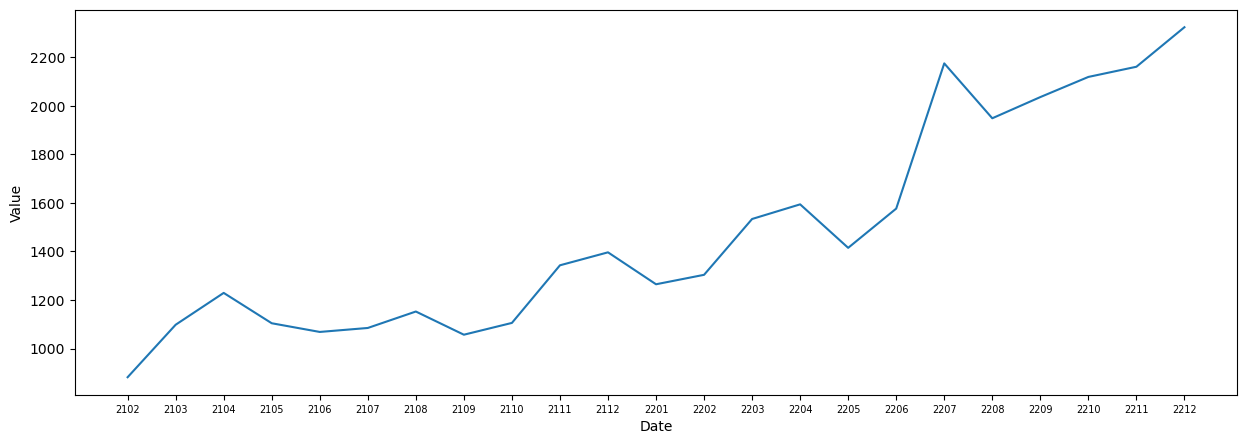

In [96]:
plt.plot(col_sum)
plt.xlabel('Date')
plt.ylabel('Value')

fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.xticks(fontsize=7)

plt.show()

In [97]:
transpose_microbusiness_density.drop(self_blacklist)

,cfips,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01,2023-03-01,2023-04-01,2023-05-01,2023-06-01,county,state
0,1001,3.007682,2.884870,3.055843,2.993233,2.993233,2.969090,2.909326,2.933231,3.000167,3.004948,3.019292,3.083837,3.174679,3.205756,3.193804,3.038416,3.002558,2.947244,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917,3.186722,3.203320,3.200948,3.286307,3.296781,3.334431,3.336785,3.372082,3.313253,3.346197,3.437971,3.423852,3.442677,3.463856,3.442677,3.470915,NaN,NaN,NaN,NaN,NaN,NaN,82,0
1,1003,7.239156,7.290936,7.425439,7.426071,7.470274,7.413655,7.282522,7.309610,7.568799,7.603275,7.708551,7.783045,7.853229,8.412239,8.329126,8.263252,8.224466,8.011045,7.909001,7.978031,8.032654,8.061466,8.077073,7.984033,7.918605,7.802155,7.832168,7.900597,7.930010,7.733397,7.823300,7.945311,7.979170,7.907365,8.507496,8.573463,8.491150,8.341701,8.359798,8.257636,8.250630,NaN,NaN,NaN,NaN,NaN,NaN,89,0
2,1005,1.073138,0.995794,1.160149,1.000628,1.000628,1.027229,1.022314,1.032144,1.086209,1.081294,0.997739,0.987909,0.982994,1.022314,1.037059,1.032144,1.032144,1.111998,1.072105,1.057146,1.102025,1.097038,1.107011,1.146903,1.156876,1.121971,1.136930,1.151890,1.151890,1.186629,1.206827,1.196728,1.191678,1.186629,1.191678,1.216926,1.196728,1.206827,1.232074,1.247223,1.252272,NaN,NaN,NaN,NaN,NaN,NaN,100,0
3,1007,1.310777,1.305176,1.254761,1.254761,1.265965,1.253638,1.248041,1.264831,1.270428,1.287217,1.304007,1.343183,1.304007,1.320797,1.326394,1.320797,1.309604,1.310044,1.287650,1.287650,1.259657,1.259657,1.237263,1.237263,1.209271,1.186877,1.186877,1.231665,1.209271,1.214165,1.236650,1.264755,1.253513,1.247892,1.275998,1.326588,1.292861,1.315346,1.287240,1.275998,1.287240,NaN,NaN,NaN,NaN,NaN,NaN,149,0
4,1009,1.544148,1.575892,1.546415,1.573625,1.555485,1.573217,1.536999,1.541526,1.577744,1.575481,1.570953,1.602644,1.604907,1.647916,1.641125,1.641125,1.613962,1.612029,1.688793,1.700081,1.702339,1.720401,1.713628,1.715885,1.711370,1.729432,1.731690,1.733947,1.752009,1.752923,1.777708,1.797986,1.764189,1.748417,1.773202,1.831783,1.836289,1.852060,1.831783,1.836289,1.852060,NaN,NaN,NaN,NaN,NaN,NaN,164,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3129,56035,6.115724,6.142085,6.181626,6.234348,6.273890,6.353848,6.486774,7.018477,6.965306,7.257743,7.297621,7.324206,7.191280,7.350791,7.324206,7.284328,7.297621,7.220456,7.750398,7.829889,7.763646,7.737149,7.710652,7.631161,7.631161,7.684154,7.710652,7.750398,7.737149,7.595103,7.687245,7.897854,7.858365,7.832039,7.739897,7.884691,7.779387,7.792550,7.792550,7.832039,7.989996,NaN,NaN,NaN,NaN,NaN,NaN,1612,50
3130,56037,2.640386,2.858371,2.913635,3.008812,3.088637,3.150922,3.169494,3.237588,3.293302,3.311873,3.126161,3.194255,3.197351,3.178779,3.163303,3.188065,3.172589,3.255770,3.534121,3.540377,3.474698,3.449678,3.487208,3.434040,3.452806,3.362107,3.255770,3.093138,3.039970,2.926768,2.892446,2.848763,2.851883,2.820681,2.783238,2.836282,2.811320,2.811320,2.823801,2.814440,2.876845,NaN,NaN,NaN,NaN,NaN,NaN,1630,50
3131,56039,26.433363,26.611856,26.736261,26.920164,26.903938,26.684565,26.738255,26.668457,27.119463,27.414764,27.506041,27.720806,27.565102,27.495302,27.441610,27.463087,27.484564,27.114956,25.209639,25.358242,25.581148,25.591763,25.655451,25.602377,25.719137,25.517462,25.628914,25.666065,25.846514,25.532248,25.438322,25.636610,25.626175,25.506157,25.652266,25.939260,26.085369,26.090586,26.273220,26.372

In [123]:
scaled_update = transpose_microbusiness_density.copy()

In [124]:
scaled_update.drop(scaled_update.columns[1:50],axis=1,inplace=True)
scaled_update = pd.concat([scaled_update,scaled_df],axis=1)

In [125]:
scaled_update

,cfips,2102,2103,2104,2105,2106,2107,2108,2109,2110,2111,2112,2201,2202,2203,2204,2205,2206,2207,2208,2209,2210,2211,2212
0,1001,0.000000,0.103992,0.324974,0.331474,0.318475,0.285977,0.311975,0.220982,0.266479,0.259979,0.493961,0.522671,0.625877,0.632328,0.729084,0.567824,0.658130,0.909695,0.870993,0.922596,0.980649,0.922596,1.000000
1,1003,0.209036,0.291208,0.356230,0.390528,0.409106,0.298353,0.220468,0.081848,0.117575,0.199032,0.234044,0.000000,0.107019,0.252259,0.292564,0.207088,0.921473,1.000000,0.902015,0.724114,0.745657,0.624045,0.615705
2,1005,0.076666,0.000000,0.229999,0.204443,0.255554,0.459997,0.511108,0.332220,0.408887,0.485553,0.485553,0.663586,0.767098,0.715343,0.689464,0.663586,0.689464,0.818854,0.715343,0.767098,0.896489,0.974122,1.000000
3,1007,0.721295,0.721295,0.520935,0.520935,0.360647,0.360647,0.160288,0.000000,0.000000,0.320576,0.160288,0.195318,0.356255,0.557426,0.476957,0.436723,0.637894,1.000000,0.758596,0.919532,0.718362,0.637894,0.718362
4,1009,0.000000,0.069142,0.082971,0.193598,0.152113,0.165941,0.138284,0.248913,0.262741,0.276569,0.387197,0.392795,0.544597,0.668798,0.461796,0.365194,0.516997,0.875800,0.903400,1.000000,0.875800,0.903400,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130,56037,0.991738,1.000000,0.913254,0.880208,0.929777,0.859555,0.884339,0.764548,0.624102,0.409304,0.339082,0.189569,0.144238,0.086542,0.090664,0.049453,0.000000,0.070058,0.037090,0.037090,0.053574,0.041211,0.123632
3131,56039,0.000000,0.127806,0.319516,0.328645,0.383420,0.337774,0.438193,0.264743,0.360597,0.392549,0.547743,0.277459,0.196678,0.367216,0.358241,0.255020,0.380681,0.627510,0.753170,0.757657,0.914731,1.000000,0.950635
3132,56041,0.147647,0.167333,0.088588,0.088588,0.000000,0.000000,0.108274,0.167333,0.196863,0.167333,0.590588,0.557363,0.842618,0.940982,1.000000,0.744254,0.773763,0.881963,0.872127,0.901636,0.921309,0.931145,0.980327
3133,56043,0.629281,1.000000,0.841120,0.682241,0.576321,0.576321,0.523361,0.364482,0.576321,0.364482,0.364482,0.264975,0.264975,0.211980,0.105990,0.000000,0.582944,0.900914,0.847918,0.847918,0.582944,0.635938,0.370965


In [126]:
#scaled_update[scaled_update.columns[1:42]] = scaled_df

In [127]:
#scaled_update = transpose_microbusiness_density

In [128]:
transpose_microbusiness_density.drop(self_blacklist).index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3123, 3124, 3126, 3127, 3128, 3129, 3130, 3131, 3132, 3133],
           dtype='int64', length=2870)

### 동적 시간 왜곡에서 최적의 k 값

In [129]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_distances
import cupy as cp

X_train = to_time_series_dataset(scaled_df.loc[transpose_microbusiness_density.drop(self_blacklist).index])
kmeans = TimeSeriesKMeans(n_clusters=2, metric="dtw")
kmeans.fit(X_train)
y_pred = kmeans.labels_

print((len(y_pred)))
print(np.unique(y_pred))
print()
print()

kmeans2 = TimeSeriesKMeans(n_clusters=9, metric="dtw")
kmeans2.fit(X_train)
y_pred2 = kmeans2.labels_

transpose_microbusiness_density.loc[transpose_microbusiness_density.drop(self_blacklist).index,'K-means_Silhouette'] = y_pred
transpose_active.loc[transpose_microbusiness_density.drop(self_blacklist).index,'K-means_Silhouette'] = y_pred
transpose_microbusiness_density = transpose_microbusiness_density.fillna(2)

transpose_microbusiness_density.loc[transpose_microbusiness_density.drop(self_blacklist).index,'K-means_Elbow'] = y_pred2
transpose_active.loc[transpose_microbusiness_density.drop(self_blacklist).index,'K-means_Elbow'] = y_pred2
transpose_microbusiness_density = transpose_microbusiness_density.fillna(9)

X_train = to_time_series_dataset(scaled_df)
kmeans = TimeSeriesKMeans(n_clusters=2, metric="dtw")
kmeans.fit(X_train)
y_pred = kmeans.labels_

print((len(y_pred)))
print(np.unique(y_pred))
print()
print()

kmeans2 = TimeSeriesKMeans(n_clusters=9, metric="dtw")
kmeans2.fit(X_train)
y_pred2 = kmeans2.labels_


transpose_microbusiness_density['K-means_Silhouette'] = y_pred
transpose_active['K-means_Silhouette'] = y_pred

transpose_microbusiness_density['K-means_Elbow'] = y_pred2
transpose_active['K-means_Elbow'] = y_pred2

transpose_microbusiness_density.to_csv('k_means_graph_12.csv', index=False)

In [133]:
X_train = to_time_series_dataset(scaled_df)
kmeans = TimeSeriesKMeans(n_clusters=2, metric="dtw")
kmeans.fit(X_train)
y_pred = kmeans.labels_

print((len(y_pred)))
print(np.unique(y_pred))
print()
print()

kmeans2 = TimeSeriesKMeans(n_clusters=8, metric="dtw")
kmeans2.fit(X_train)
y_pred2 = kmeans2.labels_


transpose_microbusiness_density['K-means_Silhouette'] = y_pred
transpose_active['K-means_Silhouette'] = y_pred
scaled_update['K-means_Silhouette'] = y_pred

transpose_microbusiness_density['K-means_Elbow'] = y_pred2
transpose_active['K-means_Elbow'] = y_pred2
scaled_update['K-means_Elbow'] = y_pred2

transpose_microbusiness_density.to_csv('k_means_graph_50.csv', index=False)
scaled_update.to_csv('k_means_graph_scaled_update.csv', index=False)

3135
[0 1]


